In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Some global variables
file_location = "/content/drive/MyDrive/VanceAFB_tsv"
factors = ['vx mean', 'vx std', 'vx max', 'vy mean', 'vy std', 'vy min', 'vy max', 'vz mean', 'vz std', 'vz min', 'vz max', 'head mean', 'head std', 'head min', 'roll min', 'roll max', 'roll mean', 'roll std']

In [ ]:
def read_data(file_location):
    """
    Read in each dataset and convert them to a pandas dataframe.

    Input: 
      file_location: the file directory for all the sample maneuvers.
    
    Output:
      df: a pandas dataframe containing relevant statistical variables for each sample maneuvers and label
      map: a dictionary that maps maneuver name to numerical encoding.
    """
    pd.set_option('display.max_columns', None)
    dicts = {}
    columns = ['type']+factors

    for col in columns:
      dicts[col] = []

    for file in os.listdir(file_location):
      df = pd.read_csv(file_location+"/"+file, sep='\t')
      row = [file[11:-8], 
            df['vx (m/s)'].mean(), df['vx (m/s)'].std(), df['vx (m/s)'].max(), 
            df['vy (m/s)'].mean(), df['vy (m/s)'].std(), df['vy (m/s)'].min(), df['vy (m/s)'].max(), 
            df['vz (m/s)'].mean(), df['vz (m/s)'].std(), df['vz (m/s)'].min(), df['vz (m/s)'].max(),
            df['head (deg)'].mean(), df['head (deg)'].std(), df['head (deg)'].min(),
            df['roll (deg)'].min(), df['roll (deg)'].max(), df['roll (deg)'].mean(), df['roll (deg)'].std()]
      for i in range(len(row)):
        dicts[columns[i]].append(row[i])

    df = pd.DataFrame(dicts)
    df.to_csv('/content/drive/MyDrive/sample_dataset.csv', mode='a')

    factor = pd.factorize(df['type'])
    df['type'] = factor[0]
    map = {}
    for i in range(len(factor[0])):
      map[factor[0][i]] = factor[1][i]
    return df, map

In [ ]:
def transform(file_path, file_name):
  """
  Takes in a dataset and transform it into pandas dataframe with relevant variables.

  Input:
    file_path: the directory that the file is in
    file_name: the file name of the dataset
  """
  dicts = {}
  columns = factors

  for col in columns:
    dicts[col] = []
  df = pd.read_csv(file_path+'/'+file_name, sep='\t')
  
  row = [
        df[' vx (m/s)'].mean(), df[' vx (m/s)'].std(), df[' vx (m/s)'].max(), 
        df[' vy (m/s)'].mean(), df[' vy (m/s)'].std(), df[' vy (m/s)'].min(), df[' vy (m/s)'].max(), 
        df[' vz (m/s)'].mean(), df[' vz (m/s)'].std(), df[' vz (m/s)'].min(), df[' vz (m/s)'].max(),
        df[' head (deg)'].mean(), df[' head (deg)'].std(), df[' head (deg)'].min(),
        df[' roll (deg)'].min(), df[' roll (deg)'].max(), df[' roll (deg)'].mean(), df[' roll (deg)'].std()]
  for i in range(len(row)):
    dicts[columns[i]].append(row[i])
    
  return pd.DataFrame(dicts)

In [ ]:
def train_model_random_forest(df):
  """
  Train the Random Forest Classifier.

  Input:
    df: the training dataframe obtained from read_data()

  Output:
    classifier: the random forest model built from the training data
  """
  X_train = df.loc[:, df.columns != 'type']
  y_train = df['type']

  classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
  classifier.fit(X_train, y_train)
  return classifier

In [ ]:
def train_model_svm(df):
  """
  Train the Random Forest Classifier.

  Input:
    df: the training dataframe obtained from read_data()

  Output:
    classifier: the random forest model built from the training data
  """
  X_train = df.loc[:, df.columns != 'type']
  y_train = df['type']

  classifier = svm.SVC()
  classifier.fit(X_train, y_train)
  return classifier

In [ ]:
def generate_prediction(file_path, file_name, model, visualize=False):
  """
  Generates a maneuver prediction from the given dataset

  Input:
    file_path: the directory that the file is in
    file_name: the file name of the dataset
  
  Output:
    a string of maneuver name predicted from the dataset.
  """
  df_train, map = read_data(file_location)
  X_pred = transform(file_path, file_name)
  
  if model == "random_forest":
    classifier = train_model_random_forest(df_train)

    if visualize:
      # Extract single tree
      estimator = classifier.estimators_[5]

      from sklearn.tree import export_graphviz
      # Export as dot file
      export_graphviz(estimator, out_file='tree.dot', 
                      feature_names = factors,
                      class_names = list(map.values()),
                      rounded = True, proportion = False, 
                      precision = 2, filled = True)

      # Convert to png using system command (requires Graphviz)
      from subprocess import call
      call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

      # Display in jupyter notebook
      from IPython.display import Image
      Image(filename = 'tree.png')
    y_pred = classifier.predict(X_pred)

  elif model == "svm":
    classifier = train_model_svm(df_train)
    if visualize:
      # Get support vectors themselves
      support_vectors = classifier.support_vectors_

      # Visualize support vectors
      for i in factors:
        plt.scatter(df_train["type"], df_train[i])
        plt.scatter(support_vectors[:,0], support_vectors[:,1], color='red')
        plt.title('SVM based on '+i)
        plt.xlabel('Maneuvers')
        plt.ylabel(i)
        plt.show()

    y_pred = classifier.predict(X_pred)

  return map[y_pred[0]]

In [ ]:
def visualize_each_variable(df, map):
  for i in factors:
    plt.scatter(df["type"], df[i])
    plt.title(i+" within each maneuver")
    plt.xlabel('maneuver')
    plt.ylabel(i)
    plt.show()
    plt.savefig(i+'.png')

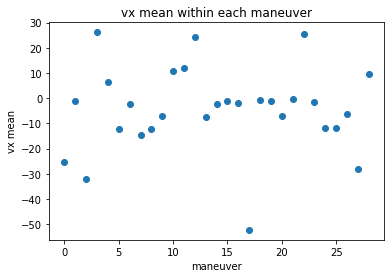

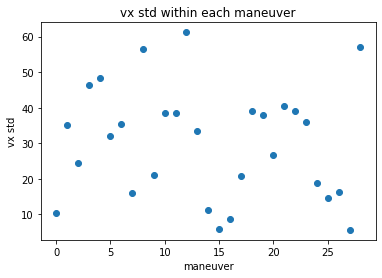

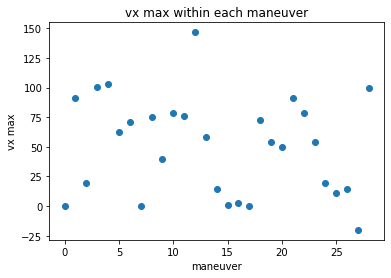

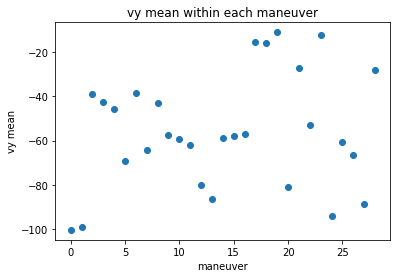

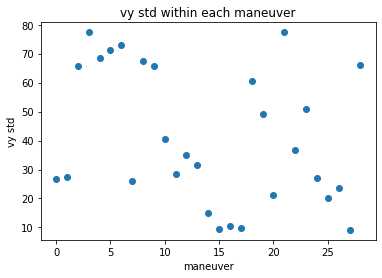

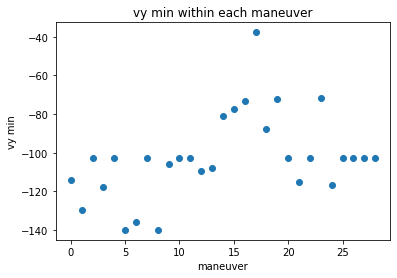

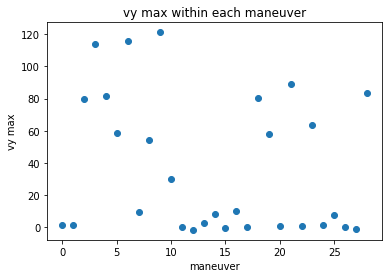

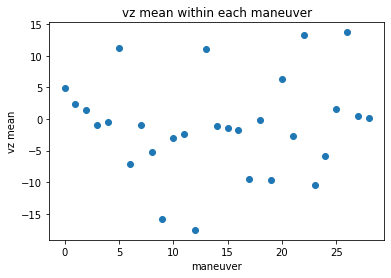

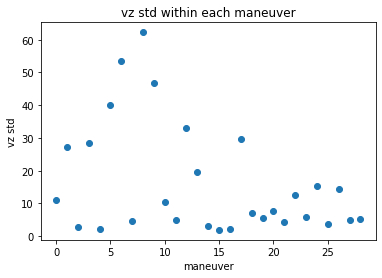

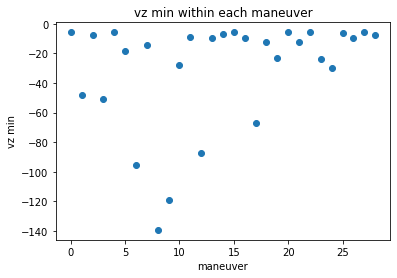

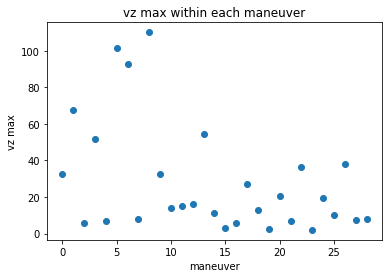

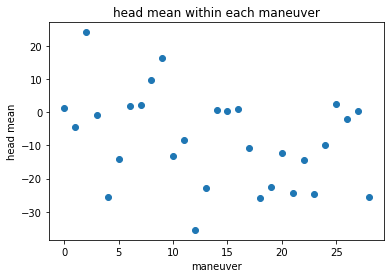

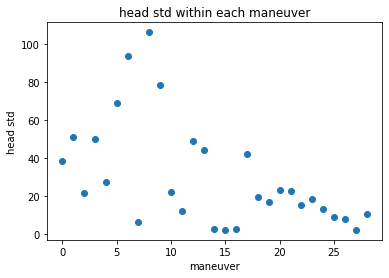

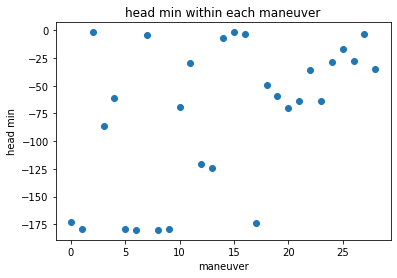

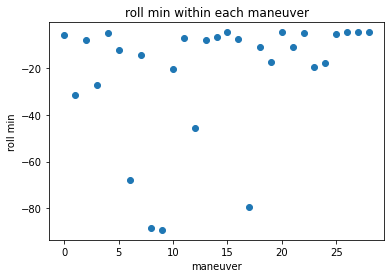

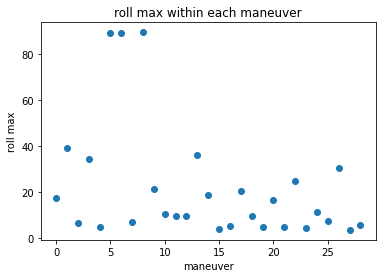

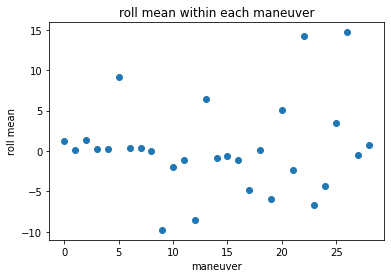

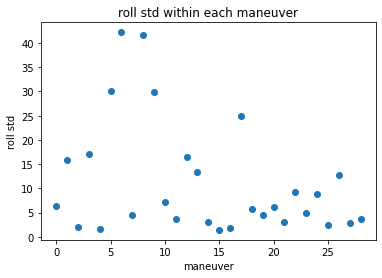

<Figure size 432x288 with 0 Axes>

In [ ]:
df, map = read_data(file_location)
visualize_each_variable(df, map)

In [ ]:
# Modify the file path and file name to output the predicted maneuver
file_path = '/content/drive/MyDrive/12000000000_tsv_good'
file_name = '12000006001.min.tsv'

result = generate_prediction(file_path, file_name, "svm", False)
print(result)

result = generate_prediction(file_path, file_name, "random_forest", False)
print(result)

45SteepTurn
45SteepTurn
